# ATMS 597: Project 5 - Part 3

Group D: Joyce Yang, Yang Lu, Lina Rivelli-Zea

Model 1: Logistic Regression classification with default values

UIUC - April, 2020

REFERENCES

Notebook: https://colab.research.google.com/drive/1Zqf6bIHAMROxYaeSTCIAQQmfaDDpPfWp#scrollTo=0kWn-CNvaHUJ

Example: https://www.kaggle.com/akdagmelih/rain-prediction-logistic-regression-example

Book: Chopra R. et. al (2019). Data Science in Python, Chapter 3 (95-133), www.packt.com

Brier: https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/

# Setup the model

In [1]:
# Import libraries
%matplotlib inline
import sys
import copy
import warnings
import matplotlib.pyplot as pyplot
import pandas as pd
import io 
import numpy as np
from pandas.tseries.offsets import MonthEnd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error
from math import sqrt
import os
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
def save_fig(fig_id, tight_layout = True, fig_extension = "png", resolution = 300):
    path = os.path.join("./", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi = resolution)

# Input data into pandas dataframe (Borrowed from part 2)

Data: KGRB (WI) 5-minute Automated Surface Observation System data available from NCDC 
    
Read 5-min ASOS observations from 2000-2020 data period

In [3]:
KGRB_precip=pd.read_csv('./KGRB_precip.csv')
KGRB_precip.describe()

,latitude,longitude,elevation,wind_direction,wind_speed,current_wx3,low_cloud_level,medium_cloud_level,high_cloud_level,highest_cloud_type,...,cloud_coverage,air_temperature,dew_point_temperature,altimeter,present_weather,past_weather,past_weather2,air_pressure_at_sea_level,eastward_wind,northward_wind
count,1.623080e+05,1.623080e+05,162308.0,161455.000000,162057.000000,0.0,160894.000000,88354.000000,36909.000000,0.0,...,162308.000000,162145.000000,161946.000000,162019.000000,162308.000000,162308.000000,162308.0,0.0,161455.000000,161455.000000
mean,4.448000e+01,-8.813000e+01,208.0,155.700907,9.607934,NaN,2235.528267,3909.013740,5626.443415,NaN,...,7.822005,4.532289,2.522668,29.847031,66.605565,6.993118,0.0,NaN,-1.081738,-1.999983
std,1.421090e-14,5.684359e-14,0.0,113.552813,5.263456,NaN,2155.368129,2619.317206,2771.096656,NaN,...,1.132625,9.432755,9.706686,0.247374,7.141335,9.315508,0.0,NaN,7.324633,7.847343
min,4.448000e+01,-8.813000e+01,208.0,0.000000,0.000000,NaN,0.000000,0.000000,900.000000,NaN,...,0.000000,-26.000000,-31.000000,20.000000,61.000000,0.000000,0.0,NaN,-31.513848,-39.392310
25%,4.448000e+01,-8.813000e+01,208.0,50.000000,6.000000,NaN,700.000000,1800.000000,3400.000000,NaN,...,8.000000,-2.000000,-4.000000,29.700000,61.000000,0.000000,0.0,NaN,-6.128356,-7.713451
50%,4.448000e+01,-8.813000e+01,208.0,150.000000,9.000000,NaN,1500.000000,3200.000000,5000.000000,NaN,...,8.000000,3.000000,2.000000,29.860000,63.000000,10.000000,0.0,NaN,-1.215537,-1.710101
75%,4.448000e+01,-8.813000e+01,208.0,250.000000,13.000000,NaN,3000.000000,5500.000000,7500.000000,NaN,...,8.000000,12.000000,10.000000,30.010000,71.000000,10.000000,0.0,NaN,3.299315,3.856726
max,4.448000e+01,-8.813000e+01,208.0,360.000000,41.000000,NaN,18000.000000,28700.000000,12000.000000,NaN,...,10.000000,34.000000,27.000000,31.030000,97.000000,49.000000,0.0,NaN,38.527397,27.000000


Targets (Snow, Rain) for Binary Classification

In [4]:
targets = ['SN', 'RA']

# Any word from `targets` are present in sentence.
precip4=KGRB_precip[KGRB_precip.current_wx1.apply(lambda sentence: any(word in sentence for word in targets))]

In [5]:
precip1=pd.DataFrame()
precip1['wind_speed']=precip4['wind_speed']
precip1['air_temperature']=precip4['air_temperature']
precip1['dew_point_temperature']=precip4['dew_point_temperature']
precip1['eastward_wind']=precip4['eastward_wind']
precip1['northward_wind']=precip4['northward_wind']
precip1['low_cloud_level']=precip4['low_cloud_level']
precip1['altimeter']=precip4['altimeter']
precip1['cloud_coverage']=precip4['cloud_coverage']
precip1['low_cloud_type']=precip4['low_cloud_type']

precip1['present_weather']=precip4['present_weather']
precip1['current_wx1']=precip4['current_wx1']

Drop mixed features (Snow and Rain)

In [6]:
precip1=precip1[precip1.current_wx1 != 'SNRA']

Binarization

In [7]:
precip1['Snow']=precip1.current_wx1.apply(lambda x: 1 if x in ['SN','-SN', '+SN'] else 0)

Drop NaN Values and weather labels

In [8]:
precip1=precip1.dropna()
precip1=precip1.drop(['current_wx1','present_weather'],axis=1)

In [9]:
precip1.describe()

,wind_speed,air_temperature,dew_point_temperature,eastward_wind,northward_wind,low_cloud_level,altimeter,cloud_coverage,Snow
count,159669.000000,159669.000000,159669.000000,159669.000000,159669.000000,159669.000000,159669.000000,159669.000000,159669.000000
mean,9.615912,4.472371,2.500886,-1.132643,-2.020768,2231.360834,29.846107,7.879876,0.416906
std,5.249853,9.342812,9.627962,7.295561,7.838090,2152.841013,0.247527,0.907281,0.493049
min,0.000000,-26.000000,-31.000000,-31.513848,-39.392310,1.000000,20.000000,2.000000,0.000000
25%,6.000000,-2.000000,-4.000000,-6.128356,-7.713451,700.000000,29.700000,8.000000,0.000000
50%,9.000000,3.000000,2.000000,-1.368081,-1.736482,1500.000000,29.860000,8.000000,0.000000
75%,13.000000,12.000000,10.000000,3.213938,3.856726,3000.000000,30.010000,8.000000,1.000000
max,40.000000,31.000000,27.000000,36.437887,27.000000,12000.000000,31.030000,10.000000,1.000000


In [10]:
X = precip1.drop('Snow',axis=1)
y = precip1['Snow']

In [11]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
X['low_cloud_type'] = ordinal_encoder.fit_transform(X['low_cloud_type'].values.reshape(-1,1))
X['low_cloud_type']

0         2.0
1         2.0
2         2.0
3         2.0
4         2.0
         ... 
162303    0.0
162304    0.0
162305    3.0
162306    0.0
162307    0.0
Name: low_cloud_type, Length: 159669, dtype: float64

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=75)

# For our matrix calculations we need to transpose our matrixis:
x_train = x_train.T
y_train = y_train.T
x_test = x_test.T
y_test = y_test.T

print('x_train shape is: ', x_train.shape)
print('y_train shape is: ', y_train.shape)
print('x_test shape is: ', x_test.shape)
print('y_test shape is: ', y_test.shape)

x_train shape is:  (9, 111768)
y_train shape is:  (111768,)
x_test shape is:  (9, 47901)
y_test shape is:  (47901,)


In [13]:
# Normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_tmp = scaler.fit_transform(x_train[:8].T)
x_train[:8] = x_train_tmp.T
x_test_tmp = scaler.transform(x_test[:8].T)
x_test[:8] = x_test_tmp.T

## Ensemble learning

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from sklearn.ensemble import VotingClassifier

In [15]:
# Parameters optimized from later steps
random_forest_clf = RandomForestClassifier(n_estimators = 400, random_state = 42)
extra_trees_clf = ExtraTreesClassifier(n_estimators = 100, random_state = 42)
svm_clf = LinearSVC(random_state = 42)
mlp_relu_clf = MLPClassifier(activation="relu", random_state = 42)
mlp_tanh_clf = MLPClassifier(activation="tanh", random_state = 42)
gbrt = GradientBoostingRegressor(n_estimators = 100, random_state = 42)
xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', random_state = 42)

In [16]:
# Test individual models
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_relu_clf, mlp_tanh_clf, gbrt, xgb_clf]
for estimator in estimators:
    print("Training the ", estimator)
    display(estimator.fit(x_train[:8].T, y_train.T))
display([estimator.score(x_test[:8].T, y_test.T) for estimator in estimators])

Training the  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Training the  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

Training the  LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)


C:\Users\YangLu\Anaconda3\envs\gpu\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

Training the  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


C:\Users\YangLu\Anaconda3\envs\gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Training the  MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


C:\Users\YangLu\Anaconda3\envs\gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Training the  GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Training the  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=42, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

[0.9880378280202918,
 0.9882048391474082,
 0.9647397757875619,
 0.9732155904887163,
 0.9724014112440241,
 0.8918052355198888,
 0.9824429552618943]

In [17]:
# Select potential models to do the hard voting
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_relu_clf", mlp_relu_clf),
    ("mlp_tanh_clf", mlp_tanh_clf),
    ("xgb_clf", xgb_clf),
]
voting_clf = VotingClassifier(named_estimators)
display(voting_clf.fit(x_train[:8].T, y_train.T))
display(voting_clf.score(x_test[:8].T, y_test.T))
display([estimator.score(x_test[:8].T, y_test.T) for estimator in voting_clf.estimators_])

C:\Users\YangLu\Anaconda3\envs\gpu\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\YangLu\Anaconda3\envs\gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\YangLu\Anaconda3\envs\gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

0.9814408884991963

[0.9880378280202918,
 0.9882048391474082,
 0.9647397757875619,
 0.9732155904887163,
 0.9724014112440241,
 0.9824429552618943]

In [18]:
# Narrow down to the best classifiers to do the soft voting
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
#     ("mlp_relu_clf", mlp_relu_clf),
#     ("mlp_tanh_clf", mlp_tanh_clf),
    ("xgb_clf", xgb_clf),
]
voting_clf = VotingClassifier(named_estimators, voting="soft")
display(voting_clf.fit(x_train.T, y_train.T))
display(voting_clf.score(x_test.T, y_test.T))
display([estimator.score(x_test.T, y_test.T) for estimator in voting_clf.estimators_])

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

0.9878708168931755

[0.9881004571929605, 0.9890398947829899, 0.983006617815912]

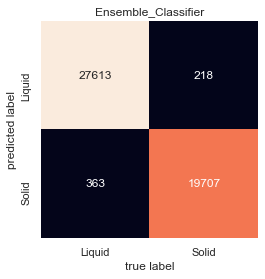

In [19]:
# Confusion matrix
predicted_prob = voting_clf.predict_proba(x_test.T)[:,1]
predicted_class = voting_clf.predict(x_test.T)
mat = confusion_matrix(y_test.T, predicted_class)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["Liquid", "Solid"],
            yticklabels=["Liquid", "Solid"])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Ensemble_Classifier");
# save_fig("Ensemble_Classifier")

In [20]:
# Bier skill score
loss = brier_score_loss(y_test.T, predicted_prob)
naive1=sum(predicted_prob)/predicted_prob.shape[0]
naive1 
yhat = [naive1 for _ in range(len(predicted_prob))]
bs_ref= brier_score_loss(y_test.T, yhat)
bs = brier_score_loss(y_test.T, predicted_prob)
bs_skill=1-(bs/bs_ref)
bs_skill

0.9603552927263799

## Random forest
Will ensemble models introduce greater bias for our task, try single models

In [28]:
params = {'n_estimators': [400]}
grid_search_cv_clf = GridSearchCV(RandomForestClassifier(), \
                             params, verbose = 0, cv = 3)
display(grid_search_cv_clf.fit(x_train.T, y_train.T))
display(grid_search_cv_clf.best_estimator_)
y_pred = grid_search_cv_clf.predict(x_test.T)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
display(grid_search_cv_clf.score(x_test.T, y_test.T))

0.9883927266654141

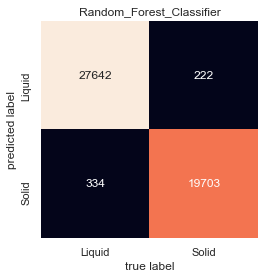

In [30]:
# Confusion matrix
predicted_prob = grid_search_cv_clf.predict_proba(x_test.T)[:,1]
predicted_class = grid_search_cv_clf.predict(x_test.T)
mat = confusion_matrix(y_test.T, predicted_class)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["Liquid", "Solid"],
            yticklabels=["Liquid", "Solid"])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Random_Forest_Classifier");
# save_fig("Random_Forest_Classifier")

In [31]:
# Bier skill score
loss = brier_score_loss(y_test.T, predicted_prob)
naive1=sum(predicted_prob)/predicted_prob.shape[0]
naive1 
yhat = [naive1 for _ in range(len(predicted_prob))]
bs_ref= brier_score_loss(y_test.T, yhat)
bs = brier_score_loss(y_test.T, predicted_prob)
bs_skill=1-(bs/bs_ref)
bs_skill

0.9616743372635755

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

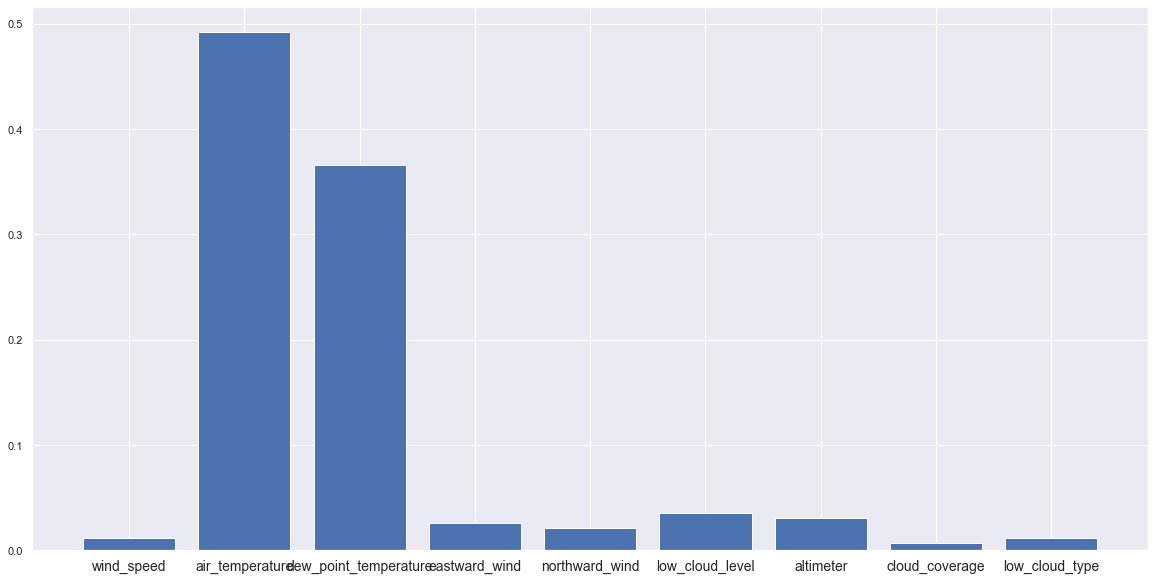

In [32]:
# Feature importances
x_bar = ['wind_speed', 'air_temperature', 'dew_point_temperature', 'eastward_wind', 'northward_wind', 'low_cloud_level', 'altimeter', 'cloud_coverage', 'low_cloud_type']
y_bar = grid_search_cv_clf.best_estimator_.feature_importances_
plt.figure(figsize=(20,10))
plt.bar(x_bar, y_bar)
plt.xticks(fontsize=14)
# save_fig("feature_importance")

## Extra Trees

In [33]:
params = {'n_estimators': [100, 200, 300, 400, 500]}
grid_search_cv_clf = GridSearchCV(ExtraTreesClassifier(), \
                             params, verbose = 0, cv = 3)
display(grid_search_cv_clf.fit(x_train.T, y_train.T))
display(grid_search_cv_clf.best_estimator_)
y_pred = grid_search_cv_clf.predict(x_test.T)

GridSearchCV(cv=3, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid='deprecate

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=300,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [34]:
display(grid_search_cv_clf.score(x_test.T, y_test.T))

0.9886849961378676

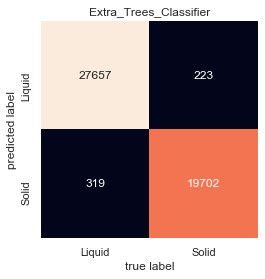

In [35]:
# Confusion matrix
predicted_prob = grid_search_cv_clf.predict_proba(x_test.T)[:,1]
predicted_class = grid_search_cv_clf.predict(x_test.T)
mat = confusion_matrix(y_test.T, predicted_class)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["Liquid", "Solid"],
            yticklabels=["Liquid", "Solid"])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Extra_Trees_Classifier");
# save_fig("Extra_Trees_Classifier")

In [36]:
# Bier skill score
loss = brier_score_loss(y_test.T, predicted_prob)
naive1=sum(predicted_prob)/predicted_prob.shape[0]
naive1 
yhat = [naive1 for _ in range(len(predicted_prob))]
bs_ref= brier_score_loss(y_test.T, yhat)
bs = brier_score_loss(y_test.T, predicted_prob)
bs_skill=1-(bs/bs_ref)
bs_skill

0.9616152797113775

Extra trees classifier could be more robust.